## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
%matplotlib inline

## Data Preparation

In [3]:
# load data
df_customer = pd.read_csv('../dataset/Case Study - Customer.csv', sep=';')
df_product = pd.read_csv('../dataset/Case Study - Product.csv', sep=';')
df_store = pd.read_csv('../dataset/Case Study - Store.csv', sep=';')
df_transaction = pd.read_csv('../dataset/Case Study - Transaction.csv', sep=';')

In [4]:
# merge data
merged_df = pd.merge(df_transaction, df_product, on='ProductID', how='left')
merged_df = pd.merge(merged_df, df_customer, on='CustomerID', how='left')
merged_df = pd.merge(merged_df, df_store, on='StoreID', how='left')
merged_df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,Crackers,7500,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR16356,165,01/01/2022,P9,10000,7,70000,1,Yoghurt,10000,44,1,Married,"14,58",Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
2,TR1984,183,01/01/2022,P1,8800,4,35200,4,Choco Bar,8800,27,1,Single,"0,18",Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
3,TR35256,160,01/01/2022,P1,8800,7,61600,4,Choco Bar,8800,48,1,Married,"12,57",Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,TR41231,386,01/01/2022,P9,10000,1,10000,4,Yoghurt,10000,33,0,Married,"6,95",Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3,Cheese Stick,15000,38,0,Married,"3,34",Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9,Ginger Candy,3200,29,0,Married,"4,74",Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9,Coffee Candy,9400,37,0,Married,"3,73",Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13,Oat,16000,47,0,Married,"13,6",Buana,Buana,General Trade,"-1,26916","116,825264"


In [5]:
# convert to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d/%m/%Y')

In [6]:
# fill missing values
merged_df['Marital Status'] = merged_df['Marital Status'].fillna(method='ffill')

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  Age             5020 non-null   int64         
 11  Gender          5020 non-null   int64         
 12  Marital Status  5020 non-null   object        
 13  Income          5020 non-null   object        
 14  StoreName       5020 non-null   object        
 15  Grou

## Regression Analysis (Time Series)

In [8]:
# create new dataframe for regression
regression_df = df_transaction.groupby('Date')['Qty'].sum().reset_index()
regression_df['Date'] = pd.to_datetime(regression_df['Date'], format='%d/%m/%Y')
regression_df.sort_values(by='Date', inplace=True)
regression_df.set_index('Date', inplace=True)
regression_df

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Quantity'>

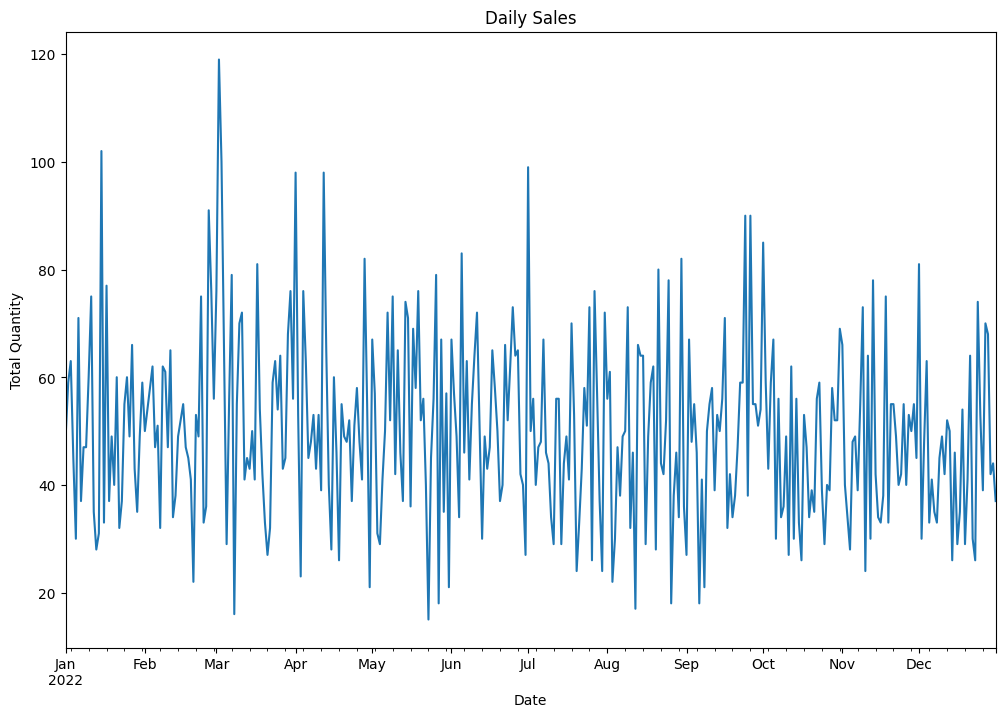

In [9]:
regression_df.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Quantity', legend=False)

In [10]:
# split data into train and test
train = regression_df[:int(0.8*(len(regression_df)))]
test = regression_df[int(0.8*(len(regression_df))):]

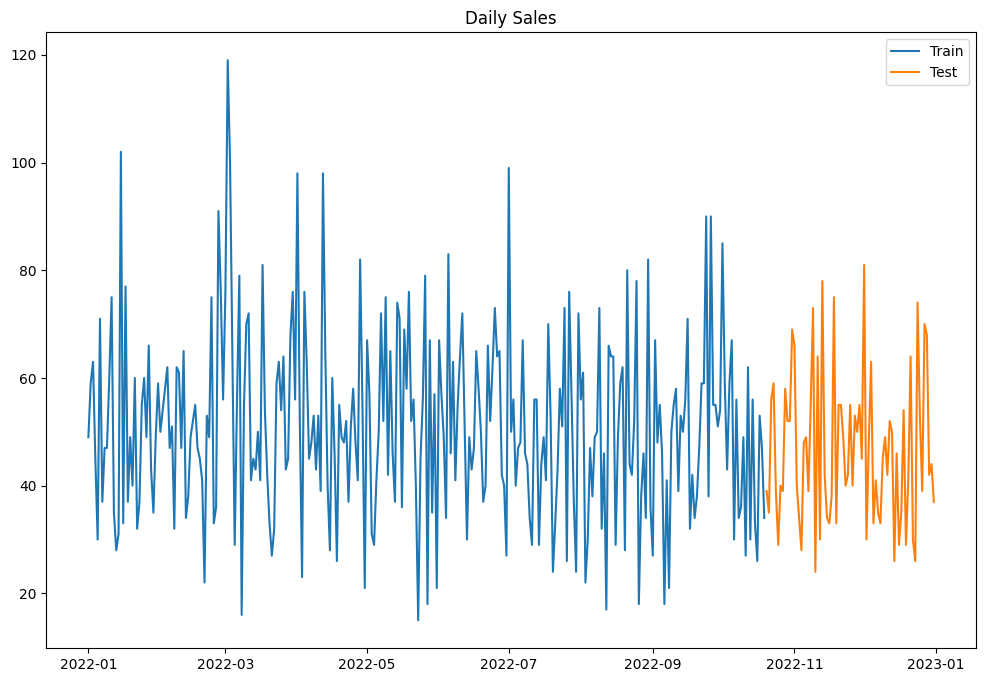

In [11]:
# plot train and test
plt.figure(figsize=(12,8))
plt.title('Daily Sales')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

### Modelling with ARIMA

#### Auto-fit ARIMA

In [18]:
# build model auto-fit ARIMA
auto_arima_model = pm.auto_arima(
    train['Qty'],
    seasonal=False,
    stepwise=False,
    suppress_warnings=True,
    trace=True
)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.32 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.30 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.33 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.70 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(3,0,0)(0,0,0)

In [19]:
# model fit auto-fit ARIMA
p, d, q = auto_arima_model.order
model_auto = SARIMAX(train['Qty'].values, order=(p,d,q))
model_auto_fit = model_auto.fit(disp=False)


#### ARIMA Manual Hyperparameter Tuning

In [12]:
# build model ARIMA manual hyperparameter tuning
from statsmodels.tsa.arima.model import ARIMA
model_manual = ARIMA(train, order=(40, 2, 2))
model_manual_fit = model_manual.fit()

c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\j

### Plot Model Prediction

C:\Users\jasmine\AppData\Local\Temp\ipykernel_10140\2075668645.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['forecast_manual'] = [None] * (len(df_plot)-len(forecast_manual)) + list(forecast_manual)
C:\Users\jasmine\AppData\Local\Temp\ipykernel_10140\2075668645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['forecast_auto'] = [None] * (len(df_plot)-len(forecast_auto)) + list(forecast_auto)


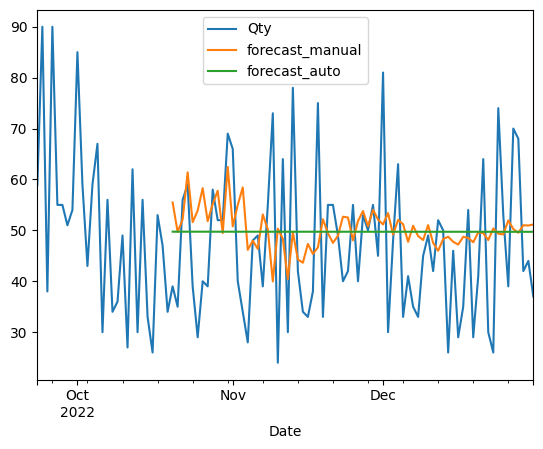

In [30]:
# forecast model
forecast_manual = model_manual_fit.forecast(len(test))
forecast_auto = model_auto_fit.forecast(len(test))

df_plot = regression_df.iloc[-100:]
df_plot['forecast_manual'] = [None] * (len(df_plot)-len(forecast_manual)) + list(forecast_manual)
df_plot['forecast_auto'] = [None] * (len(df_plot)-len(forecast_auto)) + list(forecast_auto)
df_plot.plot()
plt.show()

### Metrics Evaluation

In [31]:
# metric evaluation ARIMA manual hyperparameter tuning
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test, forecast_manual)
rmse = np.sqrt(mean_squared_error(test, forecast_manual))

print(f'mae - manual: {round(mae,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 11.9768
rmse - manual: 14.6008


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test, forecast_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 11.8542
rmse - auto: 14.1538


### Forecast Quantity Sales with The Best Parameter

#### Based On All Product

In [32]:
# model predict
model = ARIMA(regression_df, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=100)
forecast = forecast.round().astype(int)

c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jasmine\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\j

In [35]:
forecast

2023-01-01    50
2023-01-02    53
2023-01-03    43
2023-01-04    42
2023-01-05    49
              ..
2023-04-06    44
2023-04-07    45
2023-04-08    44
2023-04-09    44
2023-04-10    44
Freq: D, Name: predicted_mean, Length: 100, dtype: int32

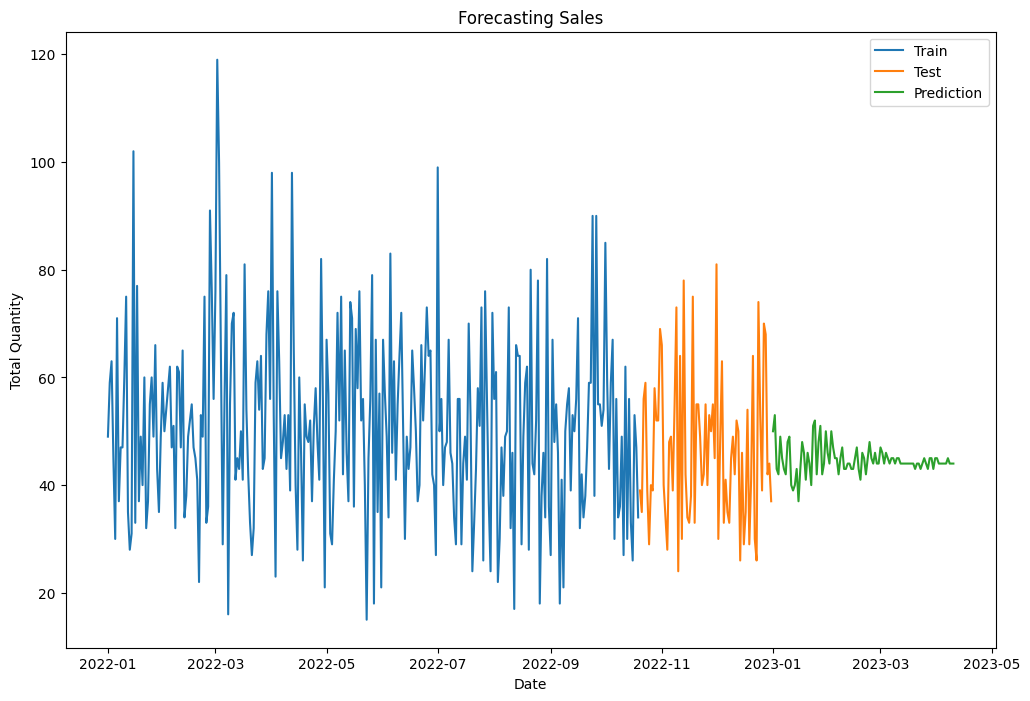

In [36]:
# plot forecasting sales
plt.figure(figsize=(12,8))
plt.title('Forecasting Sales')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [46]:
forecast.describe().astype(int)

count    100
mean      44
std        2
min       37
25%       43
50%       44
75%       45
max       53
Name: predicted_mean, dtype: int32

#### Based On Each Product

In [51]:
# forecast product for next 100 days
warnings.filterwarnings('ignore')

df_product_regression = merged_df[['Qty', 'Date', 'Product Name']]
new = df_product_regression.groupby("Product Name")

df_predict_product = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=100)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = ARIMA(target_var, order=(40, 2, 2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=100)
    forecast = forecast.round().astype(int)
    df_predict_product[product_name] = forecast.values

df_predict_product.set_index('Date', inplace=True)
df_predict_product

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-01,2,2,6,4,3,4,1,3,3,3
2023-01-02,2,3,6,4,4,4,2,3,3,3
2023-01-03,2,3,6,4,3,5,2,3,3,3
2023-01-04,2,4,6,4,3,5,2,3,3,4
2023-01-05,2,3,7,4,4,4,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...
2023-04-06,2,3,7,4,4,4,2,3,3,3
2023-04-07,2,3,6,4,4,4,2,3,3,3
2023-04-08,2,3,7,4,4,4,2,3,3,3


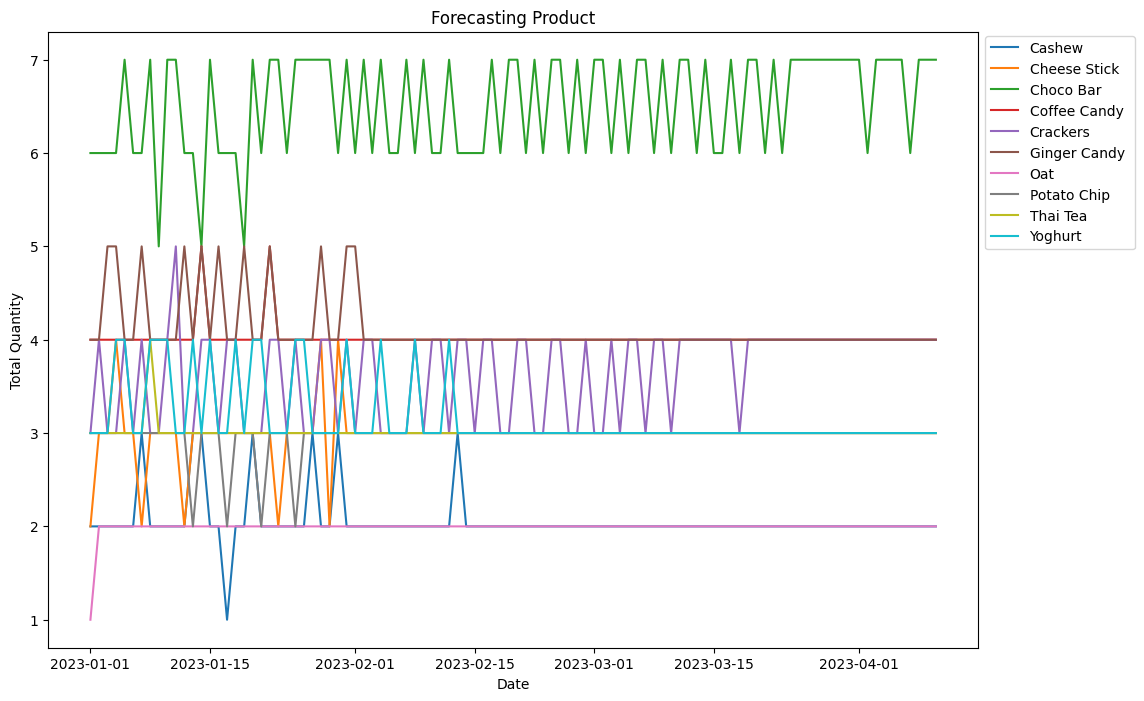

In [52]:
# plot forecasting product
plt.figure(figsize=(12,8))
for i in df_predict_product.columns:
    plt.plot(df_predict_product[i], label=i)
plt.legend(loc=6, bbox_to_anchor=(1, .82))
plt.title('Forecasting Product')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.show()

In [53]:
df_predict_product.describe().astype(int)

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
count,100,100,100,100,100,100,100,100,100,100
mean,2,2,6,4,3,4,1,2,3,3
std,0,0,0,0,0,0,0,0,0,0
min,1,2,5,4,3,4,1,2,3,3
25%,2,3,6,4,3,4,2,3,3,3
50%,2,3,7,4,4,4,2,3,3,3
75%,2,3,7,4,4,4,2,3,3,3
max,3,4,7,5,5,5,2,3,4,4
